In [1]:
from jax import config
config.update('jax_enable_x64', True)

from flax import nnx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from gpjax import Dataset
from gpjax.gps import Prior as GPPrior
from gpjax.kernels.approximations import RFF
from gpjax.kernels import RBF
from gpjax.parameters import transform

from uncprop.utils.gpjax_models import construct_gp, train_gp_hyperpars
from uncprop.utils.gpjax_multioutput import (
    BatchIndependentGP,
    get_batch_gp_from_template,
    fit_batch_independent_gp,
    _make_batched_loss_and_grad,
    _get_single_output_dataset,
)

/Users/andrewroberts/Desktop/git-repos/bip-surrogates-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# latent functions
f1 = lambda x: jnp.sin(x) + 0.3 * jnp.cos(10*x)
f2 = lambda x: -0.5 * x**2

# design data
x = jnp.linspace(0, 10, 5).reshape(-1, 1)
xgrid = jnp.linspace(0, 10, 100).reshape(-1, 1)

y = jnp.hstack([f1(x), f2(x)])
ygrid = jnp.hstack([f1(xgrid), f2(xgrid)])

design = Dataset(x, y)
testdata = Dataset(xgrid, ygrid)

In [3]:
import jax
import optax
import gpjax as gpx
from gpjax.parameters import DEFAULT_BIJECTION

opt = optax.adam(1e-1)
objective = lambda p, d: -gpx.objectives.conjugate_mll(p, d)

def gp_factory(dataset):
    return construct_gp(dataset, set_bounds=False)[0]

batchgp = get_batch_gp_from_template(gp_factory, design)

In [4]:
# Baseline for testing: computing loss/gradient one at a time (not vectorized)

def _print_tree_vals(param):
    l = param.prior.kernel.lengthscale.get_value()
    v = param.prior.kernel.variance.get_value()
    sd = param.likelihood.obs_stddev.get_value()
    m = param.prior.mean_function.constant.get_value()

    print(l, v, sd, m)


def single_losses_grads(i):
    D = _get_single_output_dataset(design, i)
    g, p, s = nnx.split(batchgp.posterior_list[i], gpx.parameters.Parameter, ...)
    phi = transform(p, DEFAULT_BIJECTION, inverse=True)

    def l(phi):
        params = transform(phi, DEFAULT_BIJECTION)
        model = nnx.merge(g, params, s)
        return objective(model, D)

    loss = l(phi)
    gradient = jax.grad(l)(phi)

    print(f'loss: {loss}')
    print('gradient:')
    _print_tree_vals(gradient)

In [5]:
# vectorized computations

loss_and_grad_vect = _make_batched_loss_and_grad(batchgp, objective, DEFAULT_BIJECTION, design)
def vectorized_losses_grads():
    phi = transform(batchgp.params, DEFAULT_BIJECTION, inverse=True)
    loss, gradient = loss_and_grad_vect(phi)

    print(f'loss: {loss}')
    print('gradient:')
    _print_tree_vals(gradient)

In [6]:
print('GP 1:')
single_losses_grads(0)

print('\nGP 2:')
single_losses_grads(1)

print('\nVectorized:')
vectorized_losses_grads()


GP 1:
loss: 2084.5677156610914
gradient:
[3081.89094655] -1641.3601269753967 -7.698937248460797e-06 47.6538068659691

GP 2:
loss: 19.407487716687505
gradient:
[0.89806426] -0.008906382813585856 -5.088002350510418e-12 0.08703846890916944

Vectorized:
loss: [2084.56771566   19.40748772]
gradient:
[[3.08189095e+03]
 [8.98064259e-01]] [-1.64136013e+03 -8.90638281e-03] [-7.69893725e-06 -5.08800235e-12] [47.65380687  0.08703847]


In [7]:
phi = transform(batchgp.params, DEFAULT_BIJECTION, inverse=True)
print(f'Starting loss: {loss_and_grad_vect(phi)[0]}')

new_batchgp, history = fit_batch_independent_gp(
    batch_gp=batchgp,
    objective=objective,
    optim=opt,
    num_iters=1000
)

phi_final = transform(new_batchgp.params, DEFAULT_BIJECTION, inverse=True)
print(f'Final loss: {loss_and_grad_vect(phi_final)[0]}')

Starting loss: [2084.56771566   19.40748772]
Final loss: [ 7.14892904 18.3240935 ]


In [8]:
xnew = jnp.array([3, 5, 6, 8]).reshape(-1, 1)
gp = new_batchgp.batch_posterior
ker = gp.prior.kernel
meanf = gp.prior.mean_function

In [9]:
# Let P denote the inverse kernel matrix
def _flip(a):
    return jnp.moveaxis(a, -1, 0)

x = xnew
X, Y = design.X, design.y
n, q = Y.shape
m = x.shape[0]

# Jitter matrices
JX = 1e-6 * jnp.eye(n)[None,:,:]
JX = jnp.broadcast_to(JX, (q,n,n))
Jx = 1e-6 * jnp.eye(m)[None,:,:]
Jx = jnp.broadcast_to(Jx, (q,m,m))

# prior means
mx = _flip(meanf(x))
mX = _flip(meanf(X))

# prior covariances
kX = _flip(ker.gram(X).to_dense()) + JX
kx = _flip(ker.gram(x).to_dense())
kxX = _flip(ker.cross_covariance(x, X))

# inverse kernel matrix
L = jnp.linalg.cholesky(kX, upper=False)
I = jnp.eye(kX.shape[-1])
I = jnp.stack([I, I])
P = jax.scipy.linalg.cho_solve((L, True), I)

# conditional mean and covariance
kxX_P = kxX @ P # (q, m, n)
m_pred = mx[..., None] + kxX_P @ (_flip(Y) - mX)[..., None] # (q, m, n) @ (q, n, 1) -> (q, m, 1)
k_pred = kx + Jx - kxX_P @ jnp.transpose(kxX, axes=(0, 2, 1))

m_pred = m_pred.squeeze(-1)


In [10]:
from uncprop.core.surrogate import GPJaxSurrogate

surr = GPJaxSurrogate(gp=new_batchgp.batch_posterior,
                      design=design)

In [15]:
def plot_gps(design, testdata, gp: GPJaxSurrogate, pred=None):
    fig, axs = plt.subplots(1, gp.output_dim)
    if gp.output_dim > 1:
        axs = axs.ravel()
    else:
        axs = [axs]

    xgrid = testdata.X.ravel()
    if pred is None:
        pred = gp(testdata.X)
    
    for i, ax in enumerate(axs):
        m = jnp.atleast_2d(pred.mean)[i]
        sd = jnp.atleast_2d(pred.stdev)[i]

        ax.fill_between(xgrid, m-2*sd, m+2*sd, alpha=0.4, color='lightblue')
        ax.plot(xgrid, testdata.y[:,i], color='black', label='true')    
        ax.plot(xgrid, m, color='blue', label='mean')
        ax.plot(design.X.ravel(), design.y[:,i], 'ro')
        ax.legend()

    fig.tight_layout()
    return fig, axs

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

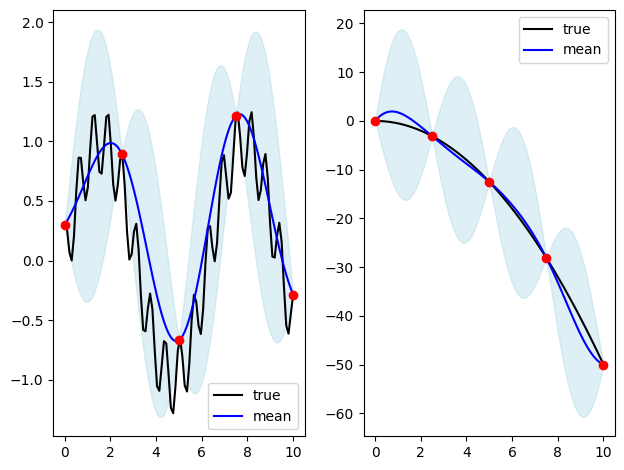

In [12]:
plot_gps(design, testdata, surr)

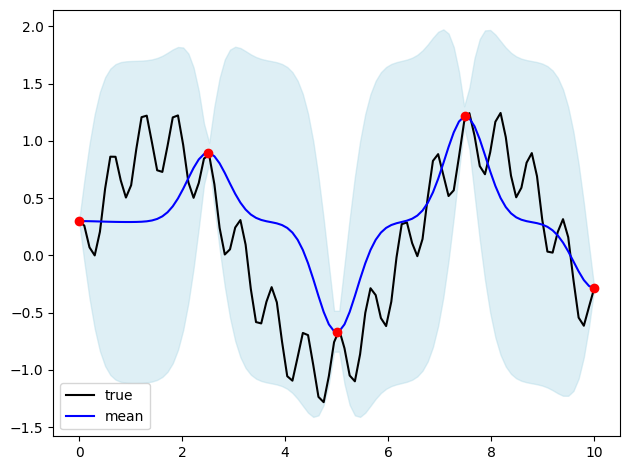

In [13]:
# single output case still works as expected
idx = 0
design_single = _get_single_output_dataset(design, idx)
testdata_single = _get_single_output_dataset(testdata, idx)

single_gp, bijection = construct_gp(design_single, set_bounds=False)
single_gp, _ = train_gp_hyperpars(single_gp, bijection, design_single)
single_surr = GPJaxSurrogate(single_gp, design_single)

fig, ax = plot_gps(design_single, testdata_single, single_surr)


(<Figure size 640x480 with 1 Axes>, [<Axes: >])

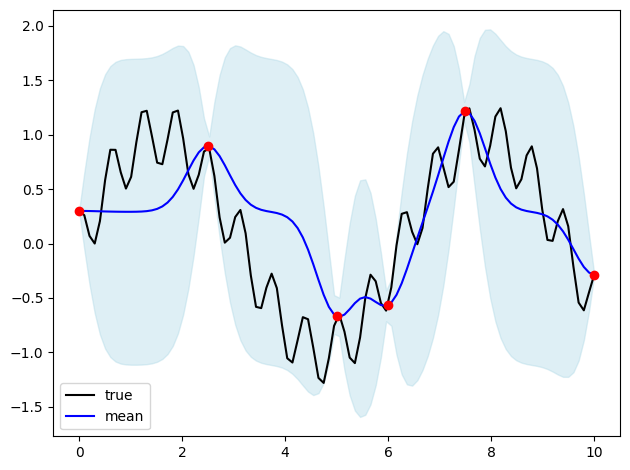

In [17]:
# conditioning methods currently only work for single-output
xnew = jnp.array([[6.0]])
ynew = f1(xnew)
newdata = Dataset(xnew, ynew)
conditional_pred = single_surr.condition_then_predict(testdata_single.X, given=(xnew, ynew))

plot_gps(design_single + newdata, testdata_single, single_surr, pred=conditional_pred)
